In [1]:
import numpy as np
import torch
import torchtext
import pickle
import csv
import unicodedata
import re, random, time, string, subprocess
import os, sys, copy
import sacrebleu
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

import matplotlib.font_manager as mfm


# Vi to En

# Data Loader

In [2]:
TEXT_vi = torchtext.data.ReversibleField(sequential=True, use_vocab=True, batch_first = False, tokenize= lambda t:t.split(),
                                        include_lengths=True)
TEXT_en = torchtext.data.ReversibleField(sequential=True, use_vocab=True, batch_first = False, tokenize= lambda t:t.split(),
                              lower=True, init_token='<sos>', eos_token='<eos>',include_lengths=True)

train_vi_en = torchtext.data.TabularDataset('../text_data/train_vi_en.csv', format='csv', 
                             fields=[('source',TEXT_vi),('target',TEXT_en)])
validation_vi_en = torchtext.data.TabularDataset('../text_data/dev_vi_en.csv', format='csv', 
                             fields=[('source',TEXT_vi),('target',TEXT_en)])
text_vi_en = torchtext.data.TabularDataset('../text_data/test_vi_en.csv', format='csv', 
                             fields=[('source',TEXT_vi),('target',TEXT_en)])



TEXT_vi.build_vocab(train_vi_en, min_freq=3)
TEXT_en.build_vocab(train_vi_en, min_freq=3)


train_vi_en_iter = torchtext.data.BucketIterator(train_vi_en, batch_size=1, sort_key= lambda e: len(e.source),
                             repeat = False, sort_within_batch=True, shuffle=True, device=torch.device(0))
validation_vi_en_iter = torchtext.data.BucketIterator(validation_vi_en, batch_size=1,
                             repeat = False, sort_within_batch=False, shuffle=False, device=torch.device(0))
text_vi_en_iter = torchtext.data.BucketIterator(text_vi_en, batch_size=1, sort_key= lambda e: len(e.source),
                             repeat = False, sort_within_batch=False, shuffle=False, device=torch.device(0))


# Load model

In [3]:
class Bi_Multi_Layer_LSTM_Encoder(torch.nn.Module):
    
    def __init__(self, num_vocab, input_size = 512, hidden_size = 512, dropout = 0.15):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = 1
        self.dropout = dropout
        
        self.dropout_layer = torch.nn.Dropout(self.dropout)
        
        self.bidirectional = True
        self.embedding_layer = torch.nn.Embedding(num_vocab, self.input_size)
        self.lstm = torch.nn.LSTM(input_size= self.input_size, hidden_size = self.hidden_size, batch_first = False,
                                 bidirectional = self.bidirectional, num_layers = self.num_layers)
        
        h_0 = torch.zeros(1, self.hidden_size)
        torch.nn.init.normal_(h_0, mean=0, std=0.0001)
        self.h_0 = torch.nn.Parameter(h_0,requires_grad=True)
        
        
        c_0 = torch.zeros(1, self.hidden_size)
        torch.nn.init.normal_(c_0, mean=0, std=0.0001)
        self.c_0 = torch.nn.Parameter(c_0,requires_grad=True)
        
        
        
        if self.bidirectional:
            h_1 = torch.zeros(1, self.hidden_size)
            torch.nn.init.normal_(h_1, mean=0, std=0.0001)
            self.h_1 = torch.nn.Parameter(h_1,requires_grad=True)
            
            
            c_1 = torch.zeros(1, self.hidden_size)
            torch.nn.init.normal_(c_1, mean=0, std=0.0001)
            self.c_1 = torch.nn.Parameter(c_1,requires_grad=True)
            
        
    def forward(self, X):
        
        X_data,X_len = X
        #X_data: source_len, 1, input_size    X_len:1,1
        
        X_data = self.embedding_layer(X_data)
        
        h_0 = torch.cat([self.h_0]*len(X_len), dim=0).unsqueeze(1)
        c_0 = torch.cat([self.c_0]*len(X_len), dim=0).unsqueeze(1)
        
        
        if self.bidirectional:
            h_1 = torch.cat([self.h_1]*len(X_len), dim=0).unsqueeze(1)
            c_1 = torch.cat([self.c_1]*len(X_len), dim=0).unsqueeze(1)
            
            h = torch.cat([h_0,h_1], dim=0)
            c = torch.cat([c_0,c_1], dim=0)   

        output, (h_n, c_n) = self.lstm(X_data, (h, c))
        #output: source_len, 1, 2*hidden_size
        h_n = h_n.view(self.num_layers, 2, len(X_len), self.hidden_size)
        c_n = c_n.view(self.num_layers, 2, len(X_len), self.hidden_size)
        
        
        return output, h_n, c_n
    
    def init_parameters(self):
        
        for name, matrix in self.lstm.named_parameters():
            if 'weight_hh_' in name:
                for i in range(0, matrix.size(0), self.hidden_size):
                    torch.nn.init.orthogonal_(matrix[i:i+self.hidden_size], gain=0.01)
            elif 'bias_' in name:
                l = len(matrix)
                matrix[l // 4: l //2].data.fill_(1.0)
                
                
class LSTM_Decoder_Without_Attention(torch.nn.Module):
    
    def __init__(self, num_vocab, input_size = 512, hidden_size = 512, dropout=0.15):
        super().__init__()
        self.num_vocab = num_vocab
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = 1
        self.dropout = dropout
        self.dropout_layer = torch.nn.Dropout(self.dropout)
        
        self.embedding_layer = torch.nn.Embedding(self.num_vocab, self.input_size)
        self.lstm = torch.nn.LSTM(hidden_size= self.hidden_size, input_size= self.input_size + 2 * self.hidden_size, 
                                  num_layers= self.num_layers)
        
        self.calcu_weight_1  = torch.nn.Linear(3*self.hidden_size, hidden_size)
        self.calcu_weight_2  = torch.nn.Linear(self.hidden_size, 1)
        
        self.init_weight_1 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.init_weight_2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        
        self.linear_vob = torch.nn.Linear(self.hidden_size, self.num_vocab)
        
        
    def forward(self, input_word_index, hidden_vector, cell_vector, encoder_memory, is_init = False):
        #input_word_index: [num]
        #hidden_vector: 1, 1, hidden_size
        #cell_vector: 1, 1, hidden_size
        #encoder_memory:  2 * hidden_size
        
        if hidden_vector.shape[0] != self.num_layers or hidden_vector.shape[2] != self.hidden_size:
            raise ValueError('The size of hidden_vector is not correct, expect '+str((self.num_layers, self.hidden_size))\
                            + ', actually get ' + str(hidden_vector.shape))
        
        if is_init:
            hidden_vector = torch.tanh(self.init_weight_1(hidden_vector))
            cell_vector = torch.tanh(self.init_weight_2(cell_vector))
            
        
        
        
        convect_vector = encoder_memory.unsqueeze(0)
        #convect_vector: 1 , 2 * hidden_size
        
        
        input_vector = self.embedding_layer(input_word_index).view(1,1,-1)
        input_vector = self.dropout_layer(input_vector)
        
        
        input_vector = torch.cat([convect_vector.unsqueeze(0), input_vector], dim=2)
        
        
        output, (h_t, c_t) = self.lstm(input_vector,(hidden_vector, cell_vector))
        output = output.view(1, self.hidden_size)
        
        
        prob = self.linear_vob(output)
        #prob 1, vob_size
        
        prob = torch.nn.functional.log_softmax(prob, dim=1)
        
        
        return prob, h_t, c_t
    
    def init_parameters(self):
        
        for name, matrix in self.lstm.named_parameters():
            if 'weight_hh_' in name:
                for i in range(0, matrix.size(0), self.hidden_size):
                    torch.nn.init.orthogonal_(matrix[i:i+self.hidden_size], gain=0.01)
            elif 'bias_' in name:
                l = len(matrix)
                matrix[l // 4: l //2].data.fill_(1.0)
                
encoder_1 = torch.load('../model/rnn_without_attention_vi/encoder_1')
decoder_1 = torch.load('../model/rnn_without_attention_vi/decoder_1')

    

/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:391: UserWarning: Couldn't retrieve source code for container of type Bi_Multi_Layer_LSTM_Encoder. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool t

# Validation bleu score for model

In [17]:
class Bean_Search_Status_Record:
    
    def __init__(self, h_t, c_t, predict_word_index_list, sum_log_prob):
        self.h_t = h_t
        self.c_t = c_t
        self.predict_word_index_list = predict_word_index_list
        self.sum_log_prob = sum_log_prob
        self.avg_log_prob = 0
        
        
        



def test(encoder, decoder, data_iter, path_name_temp, TEXT_en, k=10):
    encoder.eval()
    decoder.eval()

    path_name = '../eval/'+path_name_temp+'/'
    os.mkdir(path_name)

    predict_file_name = path_name + 'predict.txt'
    target_file_name = path_name + 'target_file_name.txt'

    predict_file = open(predict_file_name, 'w')
    target_file = open(target_file_name, 'w')


    for batch in data_iter:
        
        
        
        source, target = batch.source, batch.target
        

        source_data,source_len = source[0], source[1]
        target_data,target_len = target[0], target[1]
        
        all_output, h_n, c_n = encoder(source)
        output = c_n.flatten()

        target_word = TEXT_en.vocab.stoi['<sos>']

        h_t = h_n[:,1,:]
        c_t = c_n[:,1,:]

        is_init = True


        right_whole_sentence_word_index = target_data[1: target_len[0].item()-1,0]
        right_whole_sentence_word_index = list(right_whole_sentence_word_index.cpu().numpy())
        
        
        sequences = [Bean_Search_Status_Record(h_t, c_t, predict_word_index_list = [target_word], 
                                               sum_log_prob = 0.0)]
        
        t = 0
        while (t < 100):
            all_candidates = []
            for i in range(len(sequences)):
                record = sequences[i]
                h_t = record.h_t
                c_t = record.c_t
                predict_word_index_list = record.predict_word_index_list
                sum_log_prob = record.sum_log_prob
                target_word = predict_word_index_list[-1]
                
                if TEXT_en.vocab.stoi['<eos>'] != target_word:
                
                    prob, h_t, c_t = decoder(torch.tensor([target_word]).cuda(0), h_t, c_t, output, is_init)

                    k_prob_value_list, k_word_index_list = prob.topk(k,dim=1)
                    k_prob_value_list = k_prob_value_list.cpu().detach().squeeze().numpy()
                    k_word_index_list = k_word_index_list.cpu().squeeze().numpy()
                    
                    
                    for prob_value, word_index in zip(k_prob_value_list, k_word_index_list):
                        prob_value = float(prob_value)
                        word_index = int(word_index)
                        new_record = Bean_Search_Status_Record(h_t, c_t, predict_word_index_list+[word_index], sum_log_prob+prob_value)
                        new_record.avg_log_prob = new_record.sum_log_prob/((4+len(new_record.predict_word_index_list))**0.6/(6)**0.6)
                        all_candidates.append(new_record)
                else:
                    all_candidates.append(record)
            is_init = False
                        
            ordered = sorted(all_candidates, key = lambda r: r.avg_log_prob, reverse = True)
            sequences = ordered[:k]
            
            t += 1
        final_record = sequences[0]
        
        predict_whole_sentence_word_index = [TEXT_en.vocab.itos[temp_index] for temp_index in final_record.predict_word_index_list[1:-1]]
        right_whole_sentence_word_index = [TEXT_en.vocab.itos[temp_index] for temp_index in right_whole_sentence_word_index]

        predict_whole_sentence = ' '.join(predict_whole_sentence_word_index)
        right_whole_sentence = ' '.join(right_whole_sentence_word_index)

        predict_file.write(predict_whole_sentence.strip() + '\n')
        target_file.write(right_whole_sentence.strip() + '\n')


    predict_file.close()
    target_file.close()

    result = subprocess.run('cat {} | sacrebleu {}'.format(predict_file_name,target_file_name),shell=True,stdout=subprocess.PIPE)
    result = str(result)
    print(result)
    sys.stdout.flush()
    
    
    return get_blue_score(result)


    
def get_blue_score(s):
    a = re.search(r'13a\+version\.1\.2\.12 = ([0-9.]+)',s)
    return float(a.group(1))

In [12]:
test(encoder_1, decoder_1, validation_vi_en_iter,path_name_temp='beam_search_rnn_without_attention_vi_val', 
     TEXT_en=TEXT_en)

CompletedProcess(args='cat ../eval/beam_search_rnn_without_attention_vi_val/predict.txt | sacrebleu ../eval/beam_search_rnn_without_attention_vi_val/target_file_name.txt', returncode=0, stdout=b'BLEU+case.mixed+numrefs.1+smooth.exp+tok.13a+version.1.2.12 = 12.3 41.7/16.4/8.0/4.2 (BP = 1.000 ratio = 1.017 hyp_len = 28753 ref_len = 28275)\n')


12.3

# test data bleu score

In [13]:
test(encoder_1, decoder_1, text_vi_en_iter,path_name_temp='beam_search_rnn_without_attention_vi_test', 
     TEXT_en=TEXT_en)

CompletedProcess(args='cat ../eval/beam_search_rnn_without_attention_vi_test/predict.txt | sacrebleu ../eval/beam_search_rnn_without_attention_vi_test/target_file_name.txt', returncode=0, stdout=b'BLEU+case.mixed+numrefs.1+smooth.exp+tok.13a+version.1.2.12 = 13.5 43.1/17.4/9.2/5.2 (BP = 0.981 ratio = 0.981 hyp_len = 29442 ref_len = 30012)\n')


13.5

# relationship between blue score and sentence length

In [14]:
predict = list(open('../eval/beam_search_rnn_without_attention_vi_test/predict.txt'))
target = list(open('../eval/beam_search_rnn_without_attention_vi_test/target_file_name.txt'))

def classify_length(predict, target,l1, l2):
    pre1=[]
    tar1=[]
    if l1<50:
        for i in range(len(target)):
            if len(target[i].split())>=l1 and len(target[i].split())<l2:
                pre1.append(predict[i])
                tar1.append(target[i])
        score= sacrebleu.corpus_bleu(pre1,[tar1]).score
        a =str('The bleu score for the text length from {} to {}'.format(l1,l2))                
    else:
        for i in range(len(target)):
            if len(target[i].split())>=l1:
                pre1.append(predict[i])
                tar1.append(target[i])                
        score= sacrebleu.corpus_bleu(pre1,[tar1]).score
        a =str('The bleu score for the text length larger than {}'.format(l1))
    result = (a, score)
    
    return result

result = []
for i in range(12):
    result.append(classify_length(predict,target,i*5,(i+1)*5))
result.append(classify_length(predict,target,60,500))          

result

[('The bleu score for the text length from 0 to 5', 11.75355261199412),
 ('The bleu score for the text length from 5 to 10', 19.97024752709189),
 ('The bleu score for the text length from 10 to 15', 17.26722620178852),
 ('The bleu score for the text length from 15 to 20', 13.870007124464113),
 ('The bleu score for the text length from 20 to 25', 12.979008184979905),
 ('The bleu score for the text length from 25 to 30', 13.037543543945784),
 ('The bleu score for the text length from 30 to 35', 12.245974923171763),
 ('The bleu score for the text length from 35 to 40', 8.425290818188454),
 ('The bleu score for the text length from 40 to 45', 10.41140531520233),
 ('The bleu score for the text length from 45 to 50', 10.6494491016393),
 ('The bleu score for the text length larger than 50', 7.1300660589104545),
 ('The bleu score for the text length larger than 55', 6.618942690331497),
 ('The bleu score for the text length larger than 60', 6.5293336801806)]

In [15]:
result = np.array([(int(item[0].split(' ')[-1]),item[1]) for item in result])

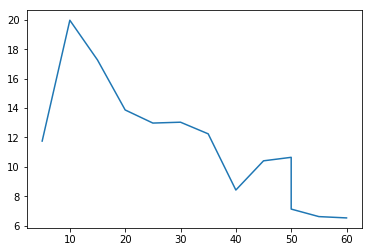

In [16]:
plt.plot(result[:,0],result[:,1])

# Load zh data

In [18]:
TEXT_zh = torchtext.data.ReversibleField(sequential=True, use_vocab=True, batch_first = False, tokenize= lambda t:t.split(),
                                        include_lengths=True)
TEXT_en = torchtext.data.ReversibleField(sequential=True, use_vocab=True, batch_first = False, tokenize= lambda t:t.split(),
                              lower=True, init_token='<sos>', eos_token='<eos>',include_lengths=True)
train_zh_en = torchtext.data.TabularDataset('../text_data/train_zh_en.csv', format='csv', 
                             fields=[('source',TEXT_zh),('target',TEXT_en)])
validation_zh_en = torchtext.data.TabularDataset('../text_data/dev_zh_en.csv', format='csv', 
                             fields=[('source',TEXT_zh),('target',TEXT_en)])
test_zh_en = torchtext.data.TabularDataset('../text_data/test_zh_en.csv', format='csv', 
                             fields=[('source',TEXT_zh),('target',TEXT_en)])



TEXT_zh.build_vocab(train_zh_en, min_freq=3)
TEXT_en.build_vocab(train_zh_en, min_freq=3)


validation_zh_en_iter = torchtext.data.BucketIterator(validation_zh_en, batch_size=1,
                             repeat = False, sort_within_batch=False, shuffle=False, device=torch.device(0))
test_zh_en_iter = torchtext.data.BucketIterator(test_zh_en, batch_size=1,
                             repeat = False, sort_within_batch=False, shuffle=False, device=torch.device(0))


In [20]:
encoder_1 = torch.load('../model/rnn_without_attention_zh/encoder_1')
decoder_1 = torch.load('../model/rnn_without_attention_zh/decoder_1')

/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:391: UserWarning: Couldn't retrieve source code for container of type Bi_Multi_Layer_LSTM_Encoder. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/qintai/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool t

# validation bleu score for model

In [21]:
test(encoder_1, decoder_1, validation_zh_en_iter,path_name_temp='beam_search_rnn_without_attention_zh_val', 
     TEXT_en=TEXT_en)

CompletedProcess(args='cat ../eval/beam_search_rnn_without_attention_zh_val/predict.txt | sacrebleu ../eval/beam_search_rnn_without_attention_zh_val/target_file_name.txt', returncode=0, stdout=b'BLEU+case.mixed+numrefs.1+smooth.exp+tok.13a+version.1.2.12 = 9.7 35.8/12.9/6.1/3.2 (BP = 1.000 ratio = 1.026 hyp_len = 30003 ref_len = 29243)\n')


9.7

# test data bleu score for model

In [22]:
test(encoder_1, decoder_1, test_zh_en_iter,path_name_temp='beam_search_rnn_without_attention_zh_test', 
     TEXT_en=TEXT_en)

CompletedProcess(args='cat ../eval/beam_search_rnn_without_attention_zh_test/predict.txt | sacrebleu ../eval/beam_search_rnn_without_attention_zh_test/target_file_name.txt', returncode=0, stdout=b'BLEU+case.mixed+numrefs.1+smooth.exp+tok.13a+version.1.2.12 = 10.8 39.9/14.8/7.6/4.1 (BP = 0.923 ratio = 0.926 hyp_len = 25088 ref_len = 27091)\n')


10.8

In [23]:
predict = list(open('../eval/beam_search_rnn_without_attention_zh_test/predict.txt'))
target = list(open('../eval/beam_search_rnn_without_attention_zh_test/target_file_name.txt'))
result = []
for i in range(12):
    result.append(classify_length(predict,target,i*5,(i+1)*5))
result.append(classify_length(predict,target,60,500))          

result

[('The bleu score for the text length from 0 to 5', 10.944553197976964),
 ('The bleu score for the text length from 5 to 10', 18.155489996013902),
 ('The bleu score for the text length from 10 to 15', 13.632923341504144),
 ('The bleu score for the text length from 15 to 20', 11.268284515955749),
 ('The bleu score for the text length from 20 to 25', 10.655752076222619),
 ('The bleu score for the text length from 25 to 30', 10.139251556007581),
 ('The bleu score for the text length from 30 to 35', 8.047592257693914),
 ('The bleu score for the text length from 35 to 40', 7.416399480307188),
 ('The bleu score for the text length from 40 to 45', 7.734336817271133),
 ('The bleu score for the text length from 45 to 50', 6.621465462337658),
 ('The bleu score for the text length larger than 50', 6.827019684785207),
 ('The bleu score for the text length larger than 55', 6.752637026573981),
 ('The bleu score for the text length larger than 60', 5.25215421719911)]

In [24]:
result = np.array([(int(item[0].split(' ')[-1]),item[1]) for item in result])

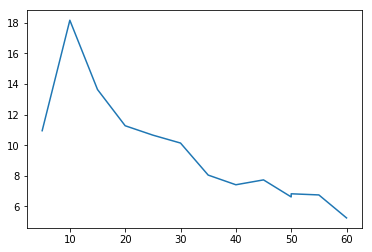

In [25]:
plt.plot(result[:,0],result[:,1])